### The German Traffic Sign Benchmark

Student Name 1: ...

Student Name 2: ...

Download full data set from http://benchmark.ini.rub.de/?section=gtsdb&subsection=dataset

In [1]:
!wget -c http://benchmark.ini.rub.de/Dataset_GTSDB/FullIJCNN2013.zip
!unzip FullIJCNN2013.zip

--2019-03-29 17:09:18--  http://benchmark.ini.rub.de/Dataset_GTSDB/FullIJCNN2013.zip
Resolving benchmark.ini.rub.de (benchmark.ini.rub.de)... 134.147.122.15
Connecting to benchmark.ini.rub.de (benchmark.ini.rub.de)|134.147.122.15|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1661866983 (1.5G) [application/zip]
Saving to: ‘FullIJCNN2013.zip’

FullIJCNN2013.zip   100%[===================>]   1.55G  8.60MB/s    in 4m 27s  

2019-03-29 17:13:51 (5.95 MB/s) - ‘FullIJCNN2013.zip’ saved [1661866983/1661866983]

Archive:  FullIJCNN2013.zip
   creating: FullIJCNN2013/
   creating: FullIJCNN2013/00/
  inflating: FullIJCNN2013/00000.ppm  
  inflating: FullIJCNN2013/00001.ppm  
  inflating: FullIJCNN2013/00002.ppm  
  inflating: FullIJCNN2013/00003.ppm  
  inflating: FullIJCNN2013/00004.ppm  
  inflating: FullIJCNN2013/00005.ppm  
  inflating: FullIJCNN2013/00006.ppm  
  inflating: FullIJCNN2013/00007.ppm  
  inflating: FullIJCNN2013/00008.ppm  
  inflating: FullIJCNN201

In [0]:
import numpy as np
import cv2

IMG_HEIGHT = 600
SIGN_SIZE = (48, 48)

# Function for reading the images
def readImages(rootpath, images_range, signs_range):
    '''Reads traffic sign data for German Traffic Sign Recognition Benchmark.
    Arguments: path to the traffic sign data, for example 'FullIJCNN2013'
    Returns:   list of images, list of corresponding labels'''
    images = {} # original image
    scales = {} # original scale
    for num in images_range:
        filename = rootpath + '/' + "{:05d}".format(num) + '.ppm'
        img = cv2.imread(filename, cv2.IMREAD_COLOR)
        scale = IMG_HEIGHT / float(img.shape[0])
        img_resized = cv2.resize(img, (int(img.shape[1]*scale),int(img.shape[0]*scale)))
        images.setdefault(filename,[]).append(img_resized)
        scales.setdefault(filename,[]).append(scale)

    files = [] # filenames
    signs = [] # traffic sign image
    bboxes = [] # corresponding box detection
    labels = [] # traffic sign type
    data = np.genfromtxt(rootpath + '/' + 'gt.txt', delimiter=';', dtype=str, usecols=range(0, 6))
    for elem in signs_range:
        filename = rootpath + '/' + data[elem][0]
        img = images.get(filename)[0]
        scale = scales.get(filename)[0]
        bbox = np.array([int(data[elem][1]), int(data[elem][2]), int(data[elem][3]), int(data[elem][4])]) * scale
        sign = img[int(bbox[1]):int(bbox[3]), int(bbox[0]):int(bbox[2])]
        sign_resized = cv2.resize(sign, SIGN_SIZE)
        files.append(filename)
        signs.append(sign_resized)
        bboxes.append(bbox)
        labels.append(data[elem][5])
    return images, files, signs, bboxes, labels

In [0]:
# The German Traffic Sign Recognition Benchmark
train_images, train_files, train_signs, train_bboxes, train_labels = readImages('FullIJCNN2013', range(0,600), range(0,852))
test_images, test_files, test_signs, test_bboxes, test_labels = readImages('FullIJCNN2013', range(600,900), range(852,1213))

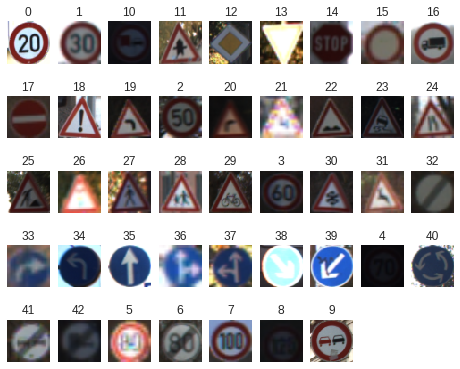

In [39]:
import matplotlib.pyplot as plt
%matplotlib inline 

# Show examples from each class
class_names = np.unique(train_labels)
num_classes = len(class_names)
fig = plt.figure(figsize=(8,8))
for i in range(num_classes):
    ax = fig.add_subplot(6, 9, 1 + i, xticks=[], yticks=[])
    ax.set_title(class_names[i])
    indices = np.where(np.isin(train_labels, class_names[i]))[0]
    plt.imshow(cv2.cvtColor(train_signs[int(np.random.choice(indices, 1))], cv2.COLOR_BGR2RGB))
plt.show()

In [0]:
from sklearn.utils import shuffle
train_files, train_signs, train_bboxes, train_labels = shuffle(train_files, train_signs, train_bboxes, train_labels)
# plt.imshow(cv2.cvtColor(train_images.get(train_files[0])[0], cv2.COLOR_BGR2RGB))
# plt.show()
# plt.imshow(cv2.cvtColor(train_signs[0], cv2.COLOR_BGR2RGB))
# plt.show()
# print(train_bboxes[0])
# print(train_labels[0])

# Data pre-processing
tr_signs = np.array(train_signs)[0:600]
tr_labels = np.array(train_labels)[0:600]
va_signs = np.array(train_signs)[600:852]
va_labels = np.array(train_labels)[600:852]
te_signs = np.array(test_signs)
te_labels = np.array(test_labels)

tr_signs = tr_signs.astype('float32')
va_signs = va_signs.astype('float32')
te_signs = te_signs.astype('float32')
tr_signs /= 255.0
va_signs /= 255.0
te_signs /= 255.0

from keras.utils import np_utils
tr_labels = np_utils.to_categorical(tr_labels, num_classes)
va_labels = np_utils.to_categorical(va_labels, num_classes)
te_labels = np_utils.to_categorical(te_labels, num_classes)

In [0]:
# Tensorboard
from time import time
from keras.callbacks import TensorBoard
tensorboard = TensorBoard(log_dir='logs/{}'.format(time()))

## Assignment 3.2: Convolutional Neural Network

In [45]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, LeakyReLU, BatchNormalization, MaxPooling2D
from keras.layers.convolutional import Conv2D
from keras.optimizers import Adam, SGD

act = LeakyReLU(alpha=0.3)

cnn = Sequential()
# convolutional layers
cnn.add(Conv2D(filters=32, strides=(1, 1), kernel_size=(3, 3), padding='same', input_shape=(SIGN_SIZE[0], SIGN_SIZE[1], 3)))
#cnn.add(BatchNormalization())
cnn.add(Activation(act))

cnn.add(Conv2D(filters=32, strides=(1, 1), kernel_size=(3, 3), padding='same'))
cnn.add(BatchNormalization())
cnn.add(Activation(act))

cnn.add(MaxPooling2D(pool_size=(2, 2))) # downscale


cnn.add(Conv2D(filters=64, strides=(1, 1), kernel_size=(3, 3), padding='same'))
cnn.add(BatchNormalization())
cnn.add(Activation(act))

cnn.add(Conv2D(filters=64, strides=(1, 1), kernel_size=(3, 3), padding='same'))
cnn.add(BatchNormalization())
cnn.add(Activation(act))

cnn.add(MaxPooling2D(pool_size=(2, 2))) # downscale

cnn.add(Conv2D(filters=128, strides=(1, 1), kernel_size=(3, 3), padding='same'))
cnn.add(BatchNormalization())
cnn.add(Activation(act))

cnn.add(Conv2D(filters=128, strides=(1, 1), kernel_size=(3, 3), padding='same'))
cnn.add(BatchNormalization())
cnn.add(Activation(act))

cnn.add(MaxPooling2D(pool_size=(2, 2))) # downscale

# dense layers
cnn.add(Flatten())
cnn.add(Dense(512))
cnn.add(BatchNormalization())
cnn.add(Activation(act))

cnn.add(Dense(num_classes))
cnn.add(Activation('softmax'))

#opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
lr = 0.01
opt = SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True)

cnn.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
cnn.summary()

/usr/local/lib/python3.6/dist-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_37 (Conv2D)           (None, 48, 48, 32)        896       
_________________________________________________________________
batch_normalization_54 (Batc (None, 48, 48, 32)        128       
_________________________________________________________________
activation_66 (Activation)   (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 48, 48, 32)        9248      
_________________________________________________________________
batch_normalization_55 (Batc (None, 48, 48, 32)        128       
_________________________________________________________________
activation_67 (Activation)   (None, 48, 48, 32)        0         
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 24, 24, 32)        0         
__________

In [46]:
data = cnn.fit(tr_signs, tr_labels, batch_size=32, epochs=30, verbose=2, validation_data=(va_signs, va_labels), callbacks=[tensorboard])

start = time()
loss, acc = cnn.evaluate(te_signs, te_labels, verbose=0)
end = time()
print('CNN took ' + str(end - start) + ' seconds')
print('Test loss: ' + str(loss) + ' - Accuracy: ' + str(acc))

Train on 600 samples, validate on 252 samples
Epoch 1/30
 - 2s - loss: 2.8054 - acc: 0.3067 - val_loss: 3.8356 - val_acc: 0.3413
Epoch 2/30
 - 1s - loss: 1.0083 - acc: 0.7050 - val_loss: 1.9137 - val_acc: 0.5397
Epoch 3/30
 - 1s - loss: 0.3855 - acc: 0.8950 - val_loss: 0.8855 - val_acc: 0.7460
Epoch 4/30
 - 1s - loss: 0.1585 - acc: 0.9800 - val_loss: 0.7281 - val_acc: 0.7778
Epoch 5/30
 - 1s - loss: 0.0827 - acc: 0.9917 - val_loss: 0.6326 - val_acc: 0.8214
Epoch 6/30
 - 1s - loss: 0.0386 - acc: 0.9983 - val_loss: 0.4860 - val_acc: 0.8611
Epoch 7/30
 - 1s - loss: 0.0194 - acc: 1.0000 - val_loss: 0.4816 - val_acc: 0.8611
Epoch 8/30
 - 1s - loss: 0.0116 - acc: 1.0000 - val_loss: 0.4653 - val_acc: 0.8651
Epoch 9/30
 - 1s - loss: 0.0084 - acc: 1.0000 - val_loss: 0.4617 - val_acc: 0.8651
Epoch 10/30
 - 1s - loss: 0.0073 - acc: 1.0000 - val_loss: 0.4626 - val_acc: 0.8651
Epoch 11/30
 - 1s - loss: 0.0068 - acc: 1.0000 - val_loss: 0.4603 - val_acc: 0.8690
Epoch 12/30
 - 1s - loss: 0.0057 - acc:

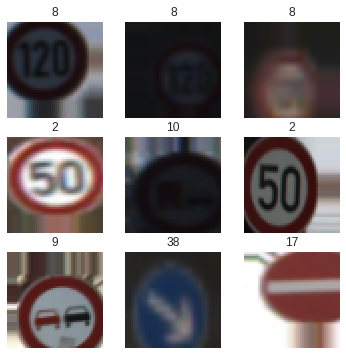

Epoch 1/100
 - 2s - loss: 2.8274 - acc: 0.2770 - val_loss: 12.4623 - val_acc: 0.1508
Epoch 2/100
 - 1s - loss: 2.4451 - acc: 0.3328 - val_loss: 4.8818 - val_acc: 0.3413
Epoch 3/100
 - 1s - loss: 2.1249 - acc: 0.4172 - val_loss: 2.6521 - val_acc: 0.5278
Epoch 4/100
 - 1s - loss: 1.7683 - acc: 0.4714 - val_loss: 2.4694 - val_acc: 0.4722
Epoch 5/100
 - 1s - loss: 1.5926 - acc: 0.5084 - val_loss: 1.6291 - val_acc: 0.5754
Epoch 6/100
 - 1s - loss: 1.4336 - acc: 0.5827 - val_loss: 1.8328 - val_acc: 0.5714
Epoch 7/100
 - 1s - loss: 1.3444 - acc: 0.5930 - val_loss: 1.2811 - val_acc: 0.6270
Epoch 8/100
 - 1s - loss: 1.1673 - acc: 0.6537 - val_loss: 4.4593 - val_acc: 0.2937
Epoch 9/100
 - 1s - loss: 1.0139 - acc: 0.6807 - val_loss: 1.0564 - val_acc: 0.6706
Epoch 10/100
 - 1s - loss: 0.8826 - acc: 0.7180 - val_loss: 1.1336 - val_acc: 0.6944
Epoch 11/100
 - 1s - loss: 0.8680 - acc: 0.7280 - val_loss: 0.9696 - val_acc: 0.7540
Epoch 12/100
 - 1s - loss: 0.8633 - acc: 0.7347 - val_loss: 0.8300 - val_

In [47]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, zoom_range=0.2, fill_mode='nearest')
datagen.fit(tr_signs, augment=True)

for x_batch, y_batch in datagen.flow(tr_signs, tr_labels, batch_size=9):
    # create a grid of 3x3 images
    fig = plt.figure(figsize=(6,6))
    for i in range(0, 9):
        ax = fig.add_subplot(3, 3, 1 + i, xticks=[], yticks=[])
        ax.set_title(np.argmax(y_batch[i]))
        plt.imshow(cv2.cvtColor(x_batch[i], cv2.COLOR_BGR2RGB))
    # show the plot
    plt.show()
    break

train_steps = int(len(tr_signs) / 16)
valid_steps = int(len(va_signs) / 16)
data = cnn.fit_generator(datagen.flow(tr_signs, tr_labels, batch_size=16), epochs=100, steps_per_epoch=train_steps, verbose=2, validation_data=(va_signs, va_labels), validation_steps=valid_steps, callbacks=[tensorboard])

start = time()
loss, acc = cnn.evaluate(te_signs, te_labels, verbose=0)
end = time()
print('CNN took ' + str(end - start) + ' seconds')
print('Test loss: ' + str(loss) + ' - Accuracy: ' + str(acc))